# CS 237 Final Project: Logistic Regression

In this final assignment of the semester, you will analyze some data from the Wisconsin Breast Cancer Data Set to determine risk factors for Breast cancer. This project is due on Thursday, December 14th at midnight. You may complete the project in teams of 2-3 people (not more) or you may elect to do it by yourself. One member of the team should submit all relevant files (specified at the end of this notebook), and the names of all team members should be on all documents. All members will receive the same grade. This project is worth 5% of your final grade and may not be skipped. 

#### Abdulshaheed Alqunber (asq@bu.edu)
#### Anuj Jain (anuj12@bu.edu)
#### Karan Mago (kmago@bu.edu)
#### Wayne Snyder CS237


In [141]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from collections import Counter
from sklearn import decomposition
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
np.seterr(divide="ignore")

{'divide': 'ignore', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [142]:
def find(name, path): #Helper method for locating files
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)
path =  find('Wisconsin_breast_cancer.csv', "." )
path

'./Wisconsin_breast_cancer.csv'

# Project Overview
The American Cancer Society estimates that at the end of this year, 252,710 women will have been diagnosed with a new case of invasive breast cancer.  Since the prognosis of a patient diagnosed with an invasive form of breast cancer improves drastically the earlier the cancer is caught, it is imperative to reexamine current diagnostic methods using the most recent technologies, such as machine learning.    

The dataset you will analyze for your paper is the
 Wisconsin breast cancer data set. The collection contains a list of relevant features computed from a digitized image of a Fine Needle Biopsy (FNA) of a breast cancer growth, in which cells from a suspicious growth in the breast are removed by a needle.  The dataset contains 683 entries, each with 10 features with a class identifier, to distinguish between benign and malignant tumors. 
 
 Here the term $\textit{benign}$ refers to a tumor, condition, or growth that is not cancerous and unlikely to metastasize (spread). In particular, benign tumors are localized and slow-growing, meaning they have not spread to other parts of the body and are unlikely to do so in the future. That being said, if a tumor gets large enough, it has the potential to press against blood vessels and nerves which can cause problems. Benign tumors can  usually be removed via surgery. On the other hand, if a tumor has the potential to, or already has spread to other parts of the body, this tumor is said to be $\textit{malignant}$. This type of tumor possesses an immediate risk as it has the potential to spread to the lymphatic system or circulatory system. If the cancer spreads to other regions of the body, it becomes significantly more difficult to treat as localized surgery will no longer remove all of the dangerous cells. 
 
 Your job for this project is to  construct a predictive model that takes as input a feature vector of values available  from a FNA and predicts whether or not the patient has cancer. The mathematical model we will use for prediction is called **Logistic Regression**. Don't let the name fool you, this is a mathematical model for classification, a common operation in machine learning.
 

 

# Data 

The data is found in the associated file <code>Wisconsin_breast_cancer.csv</code>, which contains 683 records (each representing an individual) as shown in the next cell. The records have the following numeric fields which represent data collected about each individual. 

- ID number (not used in the analysis)

- <code>Clump Thickness</code>: Benign cells tend to be grouped in mono-layers, while cancerous cells are often grouped in multiple layers. 

- <code>Uniformity of Cell Size</code> and
- <code>Uniformity of Cell Shape</code>: Cancer cells tend to vary in size and shape, and larger tumors may be growing and hence non-benign, so these parameters are valuable in determining whether the cells are cancerous or not.

- <code>Marginal Adhesion</code>: Normal cells tend to stick together and cancerous cells tend to lose this ability; hence loss of adhesion is a sign of malignancy. 

- <code>Single Epithelial Cell Size</code>: This is related to the uniformity mentioned above. Epithelial cells that are significantly enlarged may be malignant. 

- <code>Bare Nuclei</code>:  This is a term used for nuclei that is not surrounded by cytoplasm (the rest of the cell). These are typically seen in benign tumors. 

- <code>Bland Chromatin</code>: This describes a uniform "texture" of the nucleus seen in benign cells. In cancer cells the chromatin tends to be coarser.

- <code>Normal Nucleoli</code>: 
Nucleoli are small structures seen in the nucleus. In normal cells the nucleolus is usually very small if visible at all. In malignant cells the nucleoli become more prominent and numerous. 

- <code>Mitoses</code>: Cancerous cells tend to undergo mitosis more rapidly and more frequently than healthy cells.  

- <code>Target</code>: The result for this individual: 0.0 for benign, 1.0 for malignant

More information about the dataset may be found here : https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original).


In [143]:
!pwd

/Users/Ashaheedq/Library/Mobile Documents/com~apple~CloudDocs/Fall 2017/CS 237/FinalProject


In [144]:
data = pd.read_csv(path, index_col=0)
data.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Target
0,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,0.0
1,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0,0.0
2,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,0.0
3,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0,0.0
4,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0,0.0


In [145]:
features = data.columns.values[:-1]
target = data.columns.values[-1]

target_map = {
    'benign':0,
    'malignant':1
}

X, Y = data[features], data[target]
Y = np.reshape(Y, (Y.shape[0],1))
 
X_orig = X.copy()
a = np.ones( (X.shape[0] , 1))
X['1'] = a
# Don't worry about the following warning

/Users/Ashaheedq/Library/Python/3.5/lib/python/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


# Logistic Regression

This project will have you will build a logistic regression model to predict whether or not a patient has breast cancer. We will cover this topic thoroughly in lectures this week, and readings/viewings have been posted on the class web page. Our purpose here is to overview the technique for the purposes of the discussion today. You will have plenty of time to flesh out the details this week.

Logistic regression is a way of adapting linear regression to a situation where the dependent variable Y (the outcome) has only two values, 0 or 1. Hence, the Y variable will follow a Bernoulli distribution, and what we want as an outcome is the probability that the result is 1 (i.e., that the individual has breast cancer), given the values of the parameters $\theta$ (similar to the parameters $\theta_0$ and $\theta_1$ in linear regression) for the model, and the particular input $x$ (the fields in each record). In technical terms, this means that logistic regression calculates the maximum likelihood (or probability) for the $\theta$ given the data. We derive the cost function assuming the probability of the outcome given x is described by:

$P(\ y=1 \; \vert \; x \ ; \ \theta \ ) = h_{\theta}(x)$ 

$P(\ y=0 \; \vert \; x \ ; \ \theta \ ) = 1 - h_{\theta}(x)$



In the technique of Maximum Likelihood, the values for the parameters in $\theta$ are calculated to be minimum for a likelihood function, which in this case is given as 

$$L(\theta) = \prod_{i=1}^{m}{h_{\theta}(x^i)}^{y^{(i)}}(1-h_{\theta}(x^i))^{1-y^{(i)}}$$

Taking the log of both sides gives

$$\log L(\theta) =\sum_{i=1}^{m} \ [ \ -y^{(i)} \log(h_\theta(x^{(i)})) \ - \ (1 - y^{(i)})\log(1-h_\theta(x^{(i)}))$$

The goal of logistic regression is to find the $\theta$ that minimizes the negative log likelihood (which is equivalent to maximizing the log likelihood  and more convenient). 
To begin, you should implement the cost function and hypothesis function. 


# Sigmoid Squashing Function 

In order to use linear regression on a Bernoulli outcome, we must adapt our linear regression techniques to a curve which relates the independent variables $x$ to a dependent variable which is a probability in the range (0,1). This is accomplished using the <i> sigmoid</i> function.  Before you start with the actual cost function, you should understand that the logistic regression hypothesis is defined as:

$h_\theta(x) = g( X \theta)$
for $X \in \mathbb{R}^{m \times n }$ ( $m$ examples, $n$ features) and $\theta \in \mathbb{R}^n$

where function g is the sigmoid function. The sigmoid function is defined as:

$g(z) = \dfrac{1}{1+e^{-z}}$

Your first step is to implement the sigmoid function. When you are finished, plot the sigmoid function, and  test the function with a scalar, a vector, and a matrix.

<b>Note: you should use numpy arrays throughout this project!</b>

In [146]:
# Solution
def g(z):
    """Sigmoid function"""
    return 1 / (1+ (np.e**(-z)))


5
0.9933071490757153

[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
[[ 0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5]]

[[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]
[[ 0.73105858]
 [ 0.73105858]
 [ 0.73105858]
 [ 0.73105858]]

[[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]
[[ 0.73105858]
 [ 0.73105858]
 [ 0.73105858]
 [ 0.73105858]]

[-1  0  2]
[ 0.26894142  0.5         0.88079708]


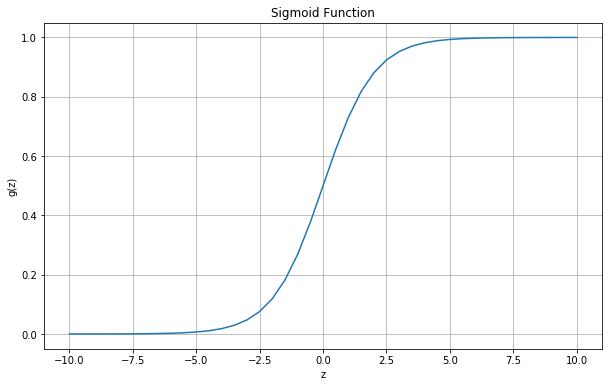

In [147]:
# test 1
s0 = 5
z0 = np.zeros((4,4))
z1 = np.ones(shape=(4,1))
z2 = np.array([-1,0,2])

print("\n"+str(s0))
print(g(s0))
print("\n"+str(z0))
print(g(z0))
print("\n"+str(z1))
print(g(z1))
print("\n"+str(z1))
print(g(z1))
print("\n"+str(z2))
print(g(z2))

plt.figure(figsize=(10,6))
plt.plot(np.arange(-10,10.5,.5) ,g( np.arange(-10,10.5,.5)))
plt.xlabel('z')
plt.ylabel('g(z)')
plt.grid(True)
plt.title("Sigmoid Function")
plt.show()

# Cost Function


Now you will implement the cost function. Complete the code
in the functions *h* and *computeCost* below to return the value of the hypothesis function and the cost, respectively. Recall that the cost function in logistic regression is

$computeCost(\theta) \ = \ \frac{1}{m} \ \sum_{i=1}^{m} \ [ \ -y^{(i)} log(h_\theta(x^{(i)})) \ - \ (1 - y^{(i)})log(1-h_\theta(x^{(i)})) \ ]$



Once you get this working, extend your code to compute the cost function for regularized logistic
regression. The regularized cost function in logistic regression is:

$computeCost(\theta;X;Y;\lambda) \ = \ [ \ \frac{1}{m} \ \sum_{i=1}^{m} \ [ \ -y^{(i)} log(h_\theta(x^{(i)})) \ - \ (1 - y^{(i)})log(1-h_\theta(x^{(i)})) \ ] \ ] \ + \frac{\lambda}{2m} \sum_{j=2}^{n} \theta_j^2 $

The log here is the natural log. Note that you should not regularize the parameter $\theta_0$ (Why not? Think about why that would be a bad idea).



In [148]:
def h(theta, X): # Logistic hypothesis function
    #return g(np.dot(theta,X))


    z = 0
    for i in range(len(theta)):
        z += X[i]*theta[i]
    return g(z)

In [149]:
def computeCost(theta,X,Y, Lambda = 0.): 
    """
    theta is an n-dimensional vector of parameters
    X is data matrix
    Y is a matrix with m-rows and 1 column of target values
    This includes regularization if you set Lambda to not be zero (make sure it is non-negative)
    """ 
    m = Y.size
    X = X.values
    Y = np.matrix(Y)

    cost = np.sum([(-Y[i][0] * np.log(h(theta, X[i].T)) - (1 - Y[i][0]) * np.log(1 - h(theta,X[i].T))) for i in range(m)]) / (m)
    reg = (Lambda / (2*m)) * np.sum([pow(theta,2) for i in range(len(theta))])
    
    ret  = cost + reg
    ret = np.nan_to_num(ret)
    if ret == 0:
        return 99999999999
    return ret

# Putting it all together
 In this section, you will implement the LogisticRegression class. We give you a skeletal outline below:
- Class LogisticRegression Attributes:
    - Lambda: regularization Parameter
    - theta: parameters for prediction
- Class LogisticRegression Functions:
    - init (given): Constructor.
    - fit(self, X,Y, Lambda) ( given): Calls optimizeRegularizedTheta to find parameters for the model. 
    - optimizeRegularizedTheta (given): Given X,Y and a method of optimization, it will find the value of theta that minimizes the cot function you coded out. It should print out the training accuracy score. 
   - predict(self, X): predicts the probabilities for all vectors in X
   - predict_class(self, X): predicts the class label for all vectors in X
   - score(self,X,Y): returns the accuracy for an input X with true labels Y
    
- Fit will use optimizeRegularizedTheta to find the optimal collection of parameters. (Either read up on how  scip.optimize.minimize works or implement the optimization yourself (not recommended) )
 

In [169]:
# A solution

class LogisticRegression:
    def __init__(self):
        self.Lambda = 0
        self.cost = None
        self.poly = None
        self.accuracy = 0

    def optimizeRegularizedTheta(self,X,Y, opt_meth = 'SLSQP'):
        result = optimize.minimize(computeCost, x0=self.theta, args=(X, Y, self.Lambda),  method=opt_meth,
                                   options={"maxiter":5000, "disp":False} )
        return np.array(result.x), result.fun
    
    def fit(self, X, Y, Lambda= None):
        self.theta = np.zeros((X.shape[1],1))
        if Lambda:
            self.Lambda =  Lambda
        self.theta, mincost = self.optimizeRegularizedTheta(X,Y)
        self.theta = np.reshape(self.theta, (len(self.theta) ,1))
        self.score(X,Y)
        
    def predict(self, X):
        X_val = X.values
        th = (np.matrix(self.theta))
        return [h(X_val[i],self.theta)[0] for i in range (len(X_val))]
    
    def score(self, X, Y):
        total = 0
        X = self.predict_class(X)
        c = []
        
        for i in range(len(Y)):
            if X[i] == Y[i][0]:
                total += 1
                c.append('True')
            else: c.append('False')
                
        self.accuracy = total/len(Y)
        
        print(Counter(c))
        print("Training Accuracy with Lambda = "+str(self.Lambda)+" "+str(self.accuracy))
        
        return self.accuracy
    
    def predict_class(self, X):
        X = self.predict(X)
        return [np.around(x, decimals=0) for x in X]

# Score on the entire Dataset

Fit a model to the entire dataset and score the accuracy.  It should be at least 80% accurate

In [151]:
clf = LogisticRegression()
clf.fit(X,Y,0)

Counter({'True': 662, 'False': 21})
Training Accuracy with Lambda = 0 0.9692532942898975


In [152]:
# Potential Thetas
clf.theta

array([[  5.37771924e-01],
       [ -7.21033154e-03],
       [  3.20301611e-01],
       [  3.32871012e-01],
       [  9.24578028e-02],
       [  3.83923882e-01],
       [  4.52240699e-01],
       [  2.12767310e-01],
       [  5.25390750e-01],
       [ -1.01010821e+01]])

# Polynomial Feature Transformation
The hypothesis for a logistic regression is the data is linearly separable. In our case, it appears that it is not.  
One way to  achieve a nonlinear decision boundary is to transform the feature space with a non-linear feature mapping. As a result of this mapping, our vector of  features will  be transformed into a $n'$-dimensional
vector. A logistic regression classifier trained on this
higher-dimension feature vector will have a more complex
decision boundary. While there are many maps we can use, we will use a polynomial feature mapping of degree 2. 

In [153]:
poly = PolynomialFeatures(2)
X_transformed = poly.fit_transform(X_orig)
X_tr = pd.DataFrame(X_transformed)
X_tr['intercept'] = a

Notice the accuracy goes up!

In [154]:
clf_poly = LogisticRegression()
clf_poly.fit(X_tr,Y,0)

Counter({'True': 671, 'False': 12})
Training Accuracy with Lambda = 0 0.9824304538799414


In [155]:
clf_poly.theta

array([[-0.55192224],
       [-0.78197746],
       [-0.23715026],
       [-0.23714916],
       [-0.29431998],
       [-0.74873108],
       [-0.19158666],
       [-0.58157485],
       [-0.20441249],
       [-0.42369593],
       [ 0.08532929],
       [-0.02517491],
       [ 0.14868892],
       [-0.22320241],
       [ 0.02620216],
       [ 0.12227246],
       [-0.02233024],
       [-0.1216687 ],
       [ 0.31998001],
       [ 0.02721483],
       [-0.19037483],
       [ 0.09347761],
       [ 0.1288287 ],
       [-0.22908437],
       [ 0.22588618],
       [ 0.0673479 ],
       [ 0.01548615],
       [ 0.04590981],
       [ 0.05579243],
       [ 0.09177291],
       [ 0.06507466],
       [ 0.05387747],
       [-0.025123  ],
       [-0.0970486 ],
       [ 0.16024733],
       [-0.09108817],
       [ 0.01149946],
       [-0.1027946 ],
       [ 0.10668141],
       [-0.06866411],
       [ 0.02106583],
       [-0.06577821],
       [ 0.18757959],
       [-0.09979592],
       [-0.04792632],
       [ 0

# Preventing Overfitting 
To try to prevent overfitting, you will split your data into 3 pieces: training, testing, and validation. 
- Train is used to fit the model
- Validate is used to find the best hyperparameter $\lambda$ 
- Test is used to evaluate the model once we have selected a good hyper parameter
Implement train_validate_test_split(X,Y) 
- takes as input X (potentially feature transformed) and Y
- returns train, test, validate (where each one is a dataframe with both features and target. Target should be at key index -1

In [156]:
#hint
X.keys()

Index(['Clump Thickness', 'Uniformity of Cell Size',
       'Uniformity of Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
       'Normal Nucleoli', 'Mitoses', '1'],
      dtype='object')

In [157]:
def train_validate_test_split(X,Y):
    # for reproducability
    np.random.seed(1234)
    X['Target'] = Y
    train, validate, test = None, None, None
    train, validate, test= np.split(X.sample(frac=1), [int(.6*len(X)), int(.8*len(X))])
    return train, validate, test

train, validate, test = train_validate_test_split(X,Y)

In [158]:
def train_validate_test_split(X,Y):
    # for reproducability
    np.random.seed(1234)
    X['Target'] = Y
    train, validate, test = None, None, None
    #train, validate, test= np.split(N.sample(frac=1), [int(.6*len(N)), int(.8*len(N))])
    
    perm = np.random.permutation(X.index)
    m = len(X)
    train_end = int(.6 * m)
    validate_end = int(.2 * m) + train_end
    train = X.iloc[perm[:train_end]]
    validate = X.iloc[perm[train_end:validate_end]]
    test = X.iloc[perm[validate_end:]]
    return train, validate, test
    
    
    #return train, validate, test

train, validate, test = train_validate_test_split(X,Y)




adopted from: 
“How to Split Data into 3 Sets (Train, Validation and Test)?” Pandas - How to Split Data into 3 Sets (Train, Validation and Test)? - Stack Overflow, stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test.

In [159]:
# Helper Function
def data_to_XY(data):
    k  = data.keys()
    X, Y = data[k[:-1]], data[k[-1]]
    Y = np.reshape(Y, (Y.shape[0],1))
    return X,Y

# Grid search for $\lambda$

Build a model using your training set for each $\lambda$ in [0,1,10,100,1000,1e6, 1e9]. Select the model that has the highest validation accuracy. Finally, compute the accuracy on testing set and return the selected model. 

In [196]:
def find_lambda(lambda_grid, X,Y):
    train, validate, test = train_validate_test_split(X,Y)
    trainX, trainY = data_to_XY(train)
    validateX, validateY = data_to_XY(validate)
    testX, testY = data_to_XY(test)
    best_lambda = 0
    best_lambda_score = 0
    best_clf = None
    s = []
    
    for i in range(len(lambda_grid)):
        clf = LogisticRegression()
        clf.fit(trainX,trainY,lambda_grid[i])
        s.append(clf.accuracy)
        print('after training')
        clf.fit(validateX,validateY,lambda_grid[i])
        print('after validating')
        if clf.accuracy > best_lambda_score: 
            best_lambda_score = clf.accuracy
            best_lambda = clf.Lambda

    print('')
    print('DONE WITH FINDING LAMBDA')
    print('')
    
    print('best lambda score: '+ str(best_lambda_score))
    clf = LogisticRegression()
    clf.fit(trainX,trainY,best_lambda)
    #clf.fit(validateX,validateY,best_lambda)
    #clf.fit(testX,testY,best_lambda)
    best_clf = clf
    return best_lambda, best_lambda_score, best_clf  , s, testX,testY

In [197]:
grid = [0,1,10,100,1000,1e6, 1e9]
_,_,clf_n ,sc, textX, textY = find_lambda(grid, X,Y)

/Users/Ashaheedq/Library/Python/3.5/lib/python/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Counter({'True': 398, 'False': 11})
Training Accuracy with Lambda = 0 0.9731051344743277
after training
Counter({'True': 135, 'False': 1})
Training Accuracy with Lambda = 0 0.9926470588235294
after validating
Counter({'True': 393, 'False': 16})
Training Accuracy with Lambda = 1 0.960880195599022
after training
Counter({'True': 132, 'False': 4})
Training Accuracy with Lambda = 1 0.9705882352941176
after validating
Counter({'True': 380, 'False': 29})
Training Accuracy with Lambda = 10 0.9290953545232273
after training
Counter({'True': 126, 'False': 10})
Training Accuracy with Lambda = 10 0.9264705882352942
after validating
Counter({'True': 345, 'False': 64})
Training Accuracy with Lambda = 100 0.843520782396088
after training
Counter({'False': 71, 'True': 65})
Training Accuracy with Lambda = 100 0.47794117647058826
after validating
Counter({'False': 262, 'True': 147})
Training Accuracy with Lambda = 1000 0.3594132029339853
after training
Counter({'False': 89, 'True': 47})
Training Accura

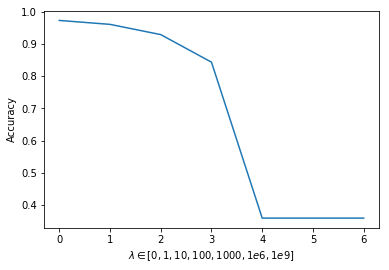

In [198]:
plt.xlabel('$\lambda \in [0,1,10,100,1000,1e6, 1e9]$')
plt.ylabel("Accuracy")
plt.plot([i for i in range(len(grid))], sc)

In [199]:
grid = [0,1,10,100,1000,1e6, 1e9]
_,_ , model, sct, testXtr, testYtr, = find_lambda(grid, X_tr,Y)

/Users/Ashaheedq/Library/Python/3.5/lib/python/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Counter({'True': 406, 'False': 3})
Training Accuracy with Lambda = 0 0.9926650366748166
after training
Counter({'True': 136})
Training Accuracy with Lambda = 0 1.0
after validating
Counter({'True': 401, 'False': 8})
Training Accuracy with Lambda = 1 0.980440097799511
after training
Counter({'True': 135, 'False': 1})
Training Accuracy with Lambda = 1 0.9926470588235294
after validating
Counter({'True': 396, 'False': 13})
Training Accuracy with Lambda = 10 0.9682151589242054
after training
Counter({'True': 133, 'False': 3})
Training Accuracy with Lambda = 10 0.9779411764705882
after validating
Counter({'True': 384, 'False': 25})
Training Accuracy with Lambda = 100 0.9388753056234719
after training
Counter({'True': 126, 'False': 10})
Training Accuracy with Lambda = 100 0.9264705882352942
after validating
Counter({'True': 318, 'False': 91})
Training Accuracy with Lambda = 1000 0.7775061124694377
after training
Counter({'False': 88, 'True': 48})
Training Accuracy with Lambda = 1000 0.352941

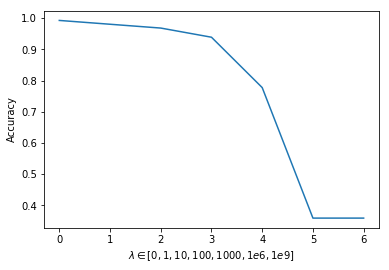

In [200]:
plt.xlabel('$\lambda \in [0,1,10,100,1000,1e6, 1e9]$')
plt.ylabel("Accuracy")
plt.plot([i for i in range(len(grid))], sct)

In [201]:
model.theta

array([[-0.59528619],
       [-0.84053528],
       [-0.30994908],
       [-0.34059029],
       [-0.44855281],
       [-0.79235309],
       [-0.40409492],
       [-0.72281374],
       [-0.22450754],
       [-0.43283633],
       [ 0.22381757],
       [ 0.05276797],
       [ 0.23183789],
       [-0.4821596 ],
       [ 0.16775696],
       [ 0.19550172],
       [-0.19719441],
       [-0.38995943],
       [ 0.25945622],
       [ 0.01058596],
       [-0.14906783],
       [ 0.20473374],
       [ 0.15774878],
       [-0.24425662],
       [ 0.25936975],
       [-0.05055938],
       [ 0.04311232],
       [-0.01852816],
       [-0.07614815],
       [-0.25369721],
       [ 0.03601176],
       [ 0.13419351],
       [ 0.1076448 ],
       [-0.10456223],
       [ 0.2101057 ],
       [-0.0489343 ],
       [ 0.14076908],
       [-0.07775505],
       [ 0.13857539],
       [-0.15028236],
       [ 0.13481169],
       [-0.11038207],
       [ 0.12312882],
       [-0.12136867],
       [ 0.05836732],
       [ 0

# Further exploration
Now you should explore how well your model performs with respect to more than just accuracy. Build the confusion matrix and report your model's sensitivity, (true positive rate), specificity (false positive rate), false negative rate, true negative and precision. Interpret your results in each case (IE, how does this metric translate to a real world decision?)
For more on the confusion matrix, see https://en.wikipedia.org/wiki/Confusion_matrix

In [202]:
y_preds = model.predict_class(testXtr)
cm = confusion_matrix(testYtr, y_preds)
cm

array([[90,  3],
       [ 7, 38]])

In [203]:
Counter(testYtr.flatten()) # Bias in testing set, more examples of clean then there are exaples of cancer!

Counter({0.0: 93, 1.0: 45})

In [206]:
def classification_summary(cm):
    # 2 class confusion matrix
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp+tn) / (tn+fp+fn+tp)
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    precision = tp/(tp+fp)
    print(tn,fp,fn,tp)
    print('accuracy: ',accuracy)
    print('sensitivity:' , sensitivity) #<-- this is a problem! Can you tihnk of how to fix it?
    print('specificity: ', specificity)
    print('precision: ', precision)
classification_summary(cm)

90 3 7 38
accuracy:  0.927536231884
sensitivity: 0.844444444444
specificity:  0.967741935484
precision:  0.926829268293


# Submission Requirements 
Select your final model. Reflect on your choice. Did you use a feature transformation? Analyze your results. You must submit your project as a Jupyter notebook containing all your code, and also a Word, Latex, or other document containing your analysis (in English). (You may also do this in a markdown cell at the end of your notebook.)  Your analysis should tell a story...

1. Title/abstract: Give your report a title and write a brief (e.g., 100-200 words)
abstract summarizing the goal, execution, and conclusions of your project.
2. Introduction: An initial section serving as both a start to the paper and an
overview
3. Background: Here you should summarize the basic prediction problem you face,
the nature of the data and the goal(s) of your work.
4. Modeling and Analysis: Describe (concisely!) the key steps you took and the
findings you obtained in the modeling and analysis of your data. These might include,
for example, descriptive analysis through visualizations and summary statistics,
transformation of variables suggested by such analysis, initial model building,
diagnostic analysis, and further key steps in the iterative process of building your
final model. For each key step and/or result, you should include a snippet of the
relevant  code in an appendix to your report.
Please note: You are not being asked here to simply list everything you tried in
analyzing the data! It is up to you to decide what is important and should be
included.You will be graded on the soundness of your judgment, as it is reflected
in the content and focus of this section.
5. Prediction: Shifting to the main goal of this exercise, you should have a separate
section describing how you did in predicting the variable of interest. 
6. Discussion: Use this section to revisit your goals, reflect on the extent to which you
feel you achieved them, how the analysis and/or the initial study (i.e,. in which
the data were obtained) could be modified the next time, and, ultimately, the
implications of your work on. For example, how could a physician leverage your model to make more informed decisions? 
7. Appendix: Here I wish to see the main snippets of  code you used in doing
your analyses. These should be illustrative. So, for example, you should not include
every call to ‘plot’ that you made. But if you include a plot(s) in your main
text, then I’d like to see the code for that in the appendix. You should include all of the code you used to build the model. **You are only allowed to use a Logistic Regression Model that you implemented yourself! This means you cannot use any package that fully implements Logistic Regression.  **

Your total report should be 2-4 pages long. 